## Sea Surface Temperature analysis

### Imported packages

In [1]:
# Numerical and data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


## 1. Data preprocessing

In [2]:
df = pd.read_csv("Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication.csv")

dlta = df[['date', 'Latitude', 'Temp (sea)']].copy()
dlta.dropna(inplace=True)
dlta.info()
dlta = dlta[dlta['Latitude']<-55]

<class 'pandas.core.frame.DataFrame'>
Index: 4950 entries, 148 to 6280
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        4950 non-null   object 
 1   Latitude    4950 non-null   float64
 2   Temp (sea)  4950 non-null   float64
dtypes: float64(2), object(1)
memory usage: 154.7+ KB


In [3]:
# Convert date to month and year
dlta['month'] = pd.to_datetime(dlta['date']).dt.month
dlta['year'] = pd.to_datetime(dlta['date']).dt.year

# Cyclic transformation of month
dlta['month_sin'] = np.sin(2 * np.pi * dlta['month'] / 12)
dlta['month_cos'] = np.cos(2 * np.pi * dlta['month'] / 12)

# Normalize year
dlta['year'] = (dlta['year'] - dlta['year'].mean()) / dlta['year'].std()

## 3. Define feature and target

In [4]:
x = dlta[['month_sin', 'month_cos', 'year', 'Latitude']]
y = dlta['Temp (sea)']

## 4. Find a good model for analysis correlation

### a. Linear regression

In [5]:
# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(x, y)

# Predict and evaluate
y_pred_lr = lr_model.predict(x)
r2_lr = r2_score(y, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
residuals_lr = y - y_pred_lr

# Print coefficients and evaluation metrics
for feature, coef in zip(x.columns, lr_model.coef_):
    print(f"Coefficient for {feature}: {coef:.4f}")
print("Intercept:", lr_model.intercept_)
print("R^2:", r2_lr)
print("RMSE:", rmse_lr)

Coefficient for month_sin: 1.5691
Coefficient for month_cos: 0.9545
Coefficient for year: 0.3062
Coefficient for Latitude: 0.0907
Intercept: 4.627617976341898
R^2: 0.24163696535649815
RMSE: 1.0775257751981764


### b. Polynomial regression (degree 2)

In [6]:
# Build pipeline with polynomial features
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

poly_model.fit(x, y)

# Predict and evaluate
y_pred_poly = poly_model.predict(x)
r2_poly = r2_score(y, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
residuals_poly = y - y_pred_poly

# Print evaluation metrics
print("R^2:", r2_poly)
print("RMSE:", rmse_poly)

R^2: 0.2746268302313629
RMSE: 1.0538282428882801


### c. Random forest

In [7]:
# Split for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
residuals_rf = y_test - y_pred_rf

# Print evaluation metrics
print("Random Forest R^2:", r2_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest R^2: 0.42941859525816795
Random Forest RMSE: 0.9089113886767688


## 5. Visualization

#### 5.0. Bar chart of counts per month

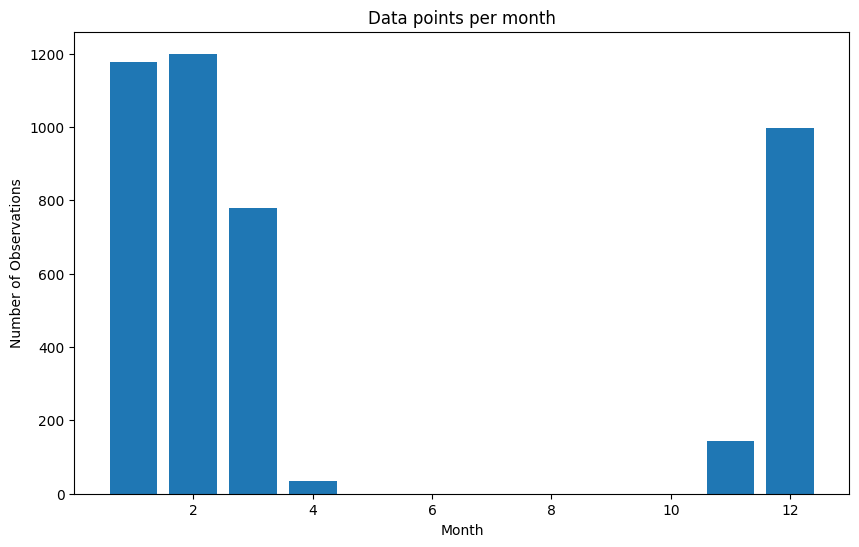

In [8]:
plt.figure(figsize=(10, 6))
counts = dlta['month'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.title('Data points per month')
plt.show()

From here, we can see that majority of the observations were concentrated in the **early and late months** of the year (January, Febuary, March, and December), while summer months (May through September) were severely underrepresented.

#### 5.1. Visualization of model

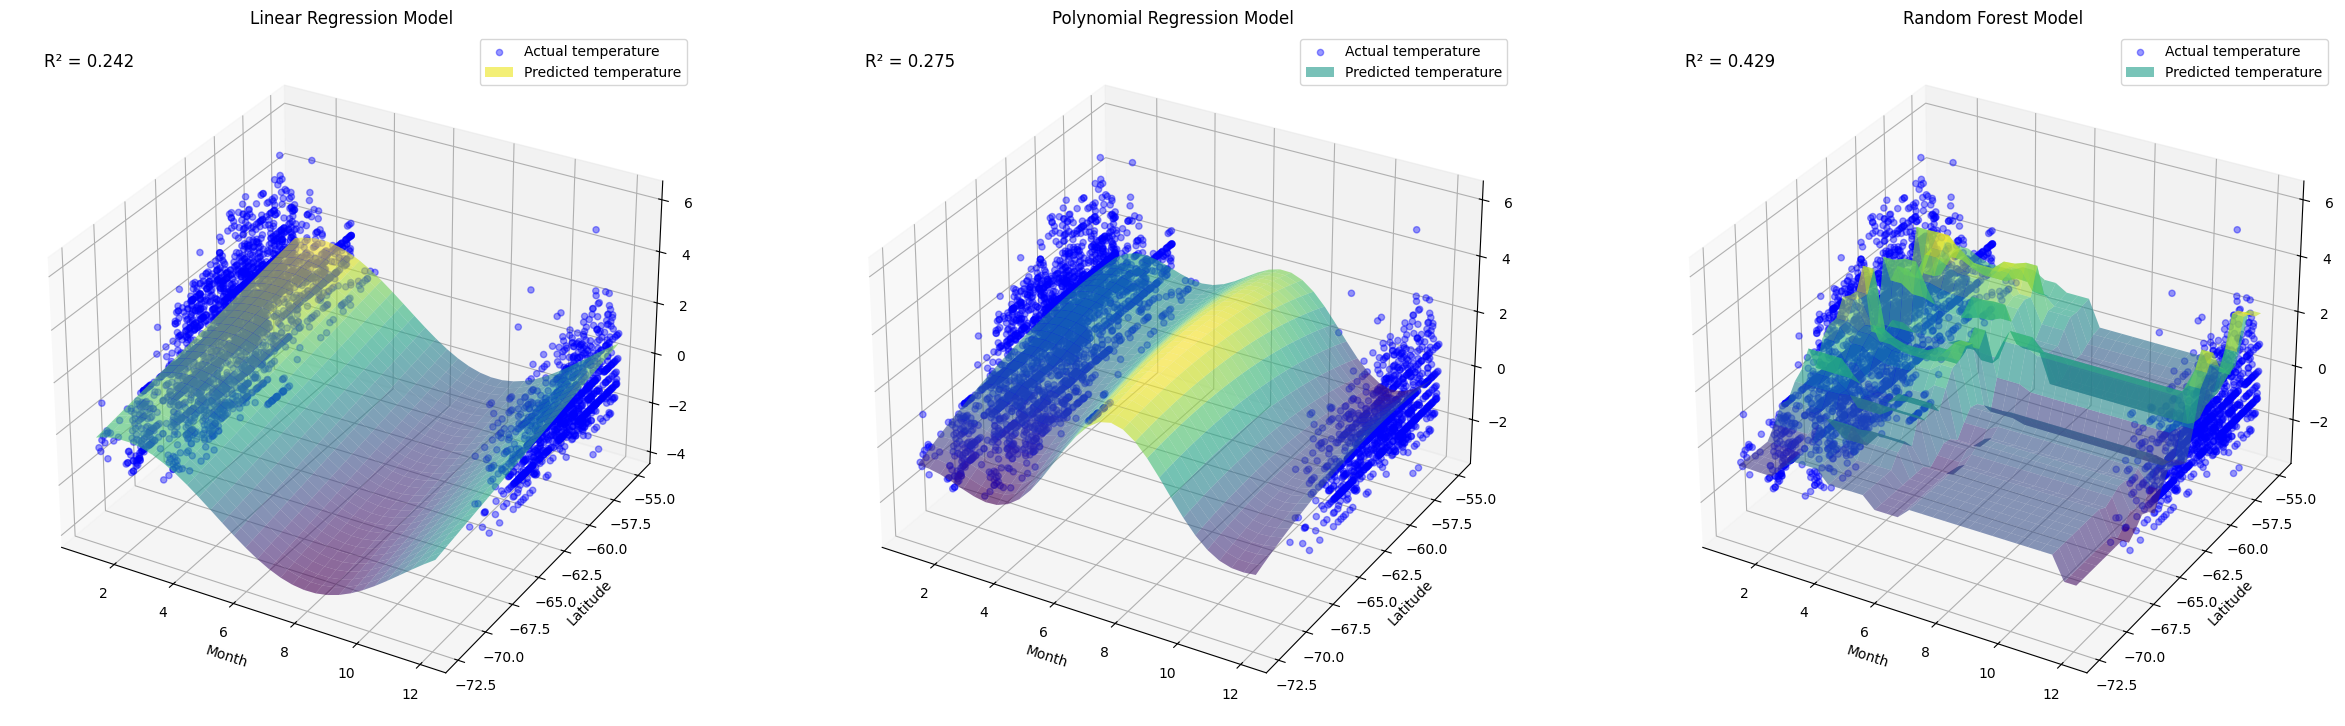

In [9]:
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')  

# Create grid of raw months and lattitudes
month_vals = np.linspace(dlta['month'].min(), dlta['month'].max(), 30)
lat_vals = np.linspace(dlta['Latitude'].min(), dlta['Latitude'].max(), 30)
month_grid, lat_grid = np.meshgrid(month_vals, lat_vals)

# Compute cyclic encodings for months
month_sin_grid = np.sin(2 * np.pi * month_grid / 12)
month_cos_grid = np.cos(2 * np.pi * month_grid / 12)

## Use the normalized average year
avg_year = 0 # (mean of the normalized year column)

# Prepare full feature grid
X_grid = np.c_[
    month_sin_grid.ravel(),
    month_cos_grid.ravel(),
    np.full(month_grid.size, avg_year),
    lat_grid.ravel()
]

# Convert to DataFrame with feature names to avoid warnings
X_grid_df = pd.DataFrame(X_grid, columns=x.columns)

#-------LINEAR REGRESSION-------
## Predic temperature using the linear regression model
temp_pred_lr_grid = lr_model.predict(X_grid_df).reshape(month_grid.shape)

## Plot the results
ax1.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual temperature', alpha=0.4)
ax1.plot_surface(month_grid, lat_grid, temp_pred_lr_grid, cmap='viridis', alpha=0.6, label='Predicted temperature')
ax1.set_xlabel('Month')
ax1.set_ylabel('Latitude')
ax1.set_title('Linear Regression Model')
ax1.text2D(0.05, 0.95, f"R² = {r2_lr:.3f}", transform=ax1.transAxes, fontsize=12)
ax1.legend()


#-------POLYNOMIAL REGRESSION-------
## Predict temperature using the polynomial regression model
temp_pred_poly_grid = poly_model.predict(X_grid_df).reshape(month_grid.shape)

## Plot the results
ax2.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual temperature', alpha=0.4)
ax2.plot_surface(month_grid, lat_grid, temp_pred_poly_grid, cmap='viridis', alpha=0.6, label='Predicted temperature')
ax2.set_xlabel('Month')
ax2.set_ylabel('Latitude')
ax2.set_title('Polynomial Regression Model')
ax2.text2D(0.05, 0.95, f"R² = {r2_poly:.3f}", transform=ax2.transAxes, fontsize=12)
ax2.legend()

#-------RANDOM FOREST REGRESSION-------
## Predict temperature using the random forest model
temp_pred_rf_grid = rf_model.predict(X_grid_df).reshape(month_grid.shape)

## Plot the results
ax3.scatter(dlta['month'], dlta['Latitude'], y, color='blue', label='Actual temperature', alpha=0.4)
ax3.plot_surface(month_grid, lat_grid, temp_pred_rf_grid, cmap='viridis', alpha=0.6, label='Predicted temperature')
ax3.set_xlabel('Month')
ax3.set_ylabel('Latitude')
ax3.set_title('Random Forest Model')
ax3.text2D(0.05, 0.95, f"R² = {r2_rf:.3f}", transform=ax3.transAxes, fontsize=12)
ax3.legend()

#### 5.2. Residuals vs Fitted

Text(0.5, 1.0, 'Random Forest Regression Residuals')

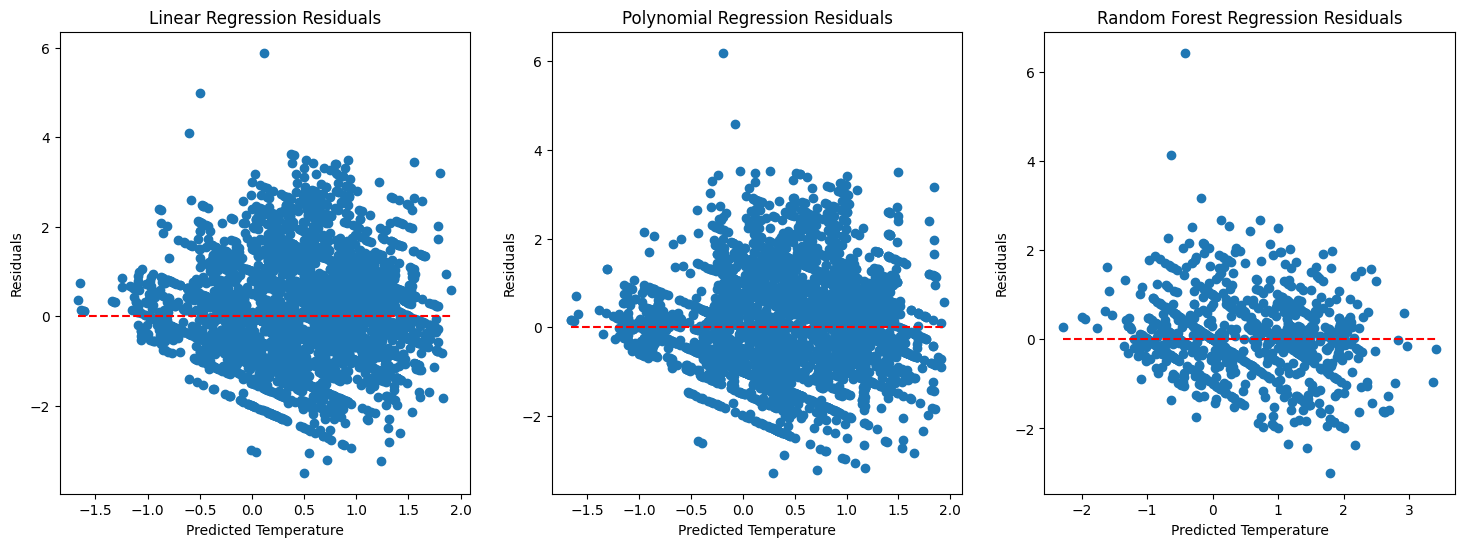

In [10]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))

#-------LINEAR REGRESSION RESIDUALS-------
ax[0].scatter(y_pred_lr, residuals_lr)
ax[0].hlines(0, y_pred_lr.min(), y_pred_lr.max(), color='red', linestyle='--')
ax[0].set_xlabel('Predicted Temperature')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Linear Regression Residuals')

#-------POLYNOMIAL REGRESSION RESIDUALS-------
ax[1].scatter(y_pred_poly, residuals_poly)
ax[1].hlines(0, y_pred_poly.min(), y_pred_poly.max(), color='red', linestyle='--')
ax[1].set_xlabel('Predicted Temperature')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Polynomial Regression Residuals')

#-------RANDOM FOREST REGRESSION RESIDUALS-------
ax[2].scatter(y_pred_rf, residuals_rf)
ax[2].hlines(0, y_pred_rf.min(), y_pred_rf.max(), color='red', linestyle='--')
ax[2].set_xlabel('Predicted Temperature')
ax[2].set_ylabel('Residuals')
ax[2].set_title('Random Forest Regression Residuals')

#### 5.3. Predicted vs Actual 

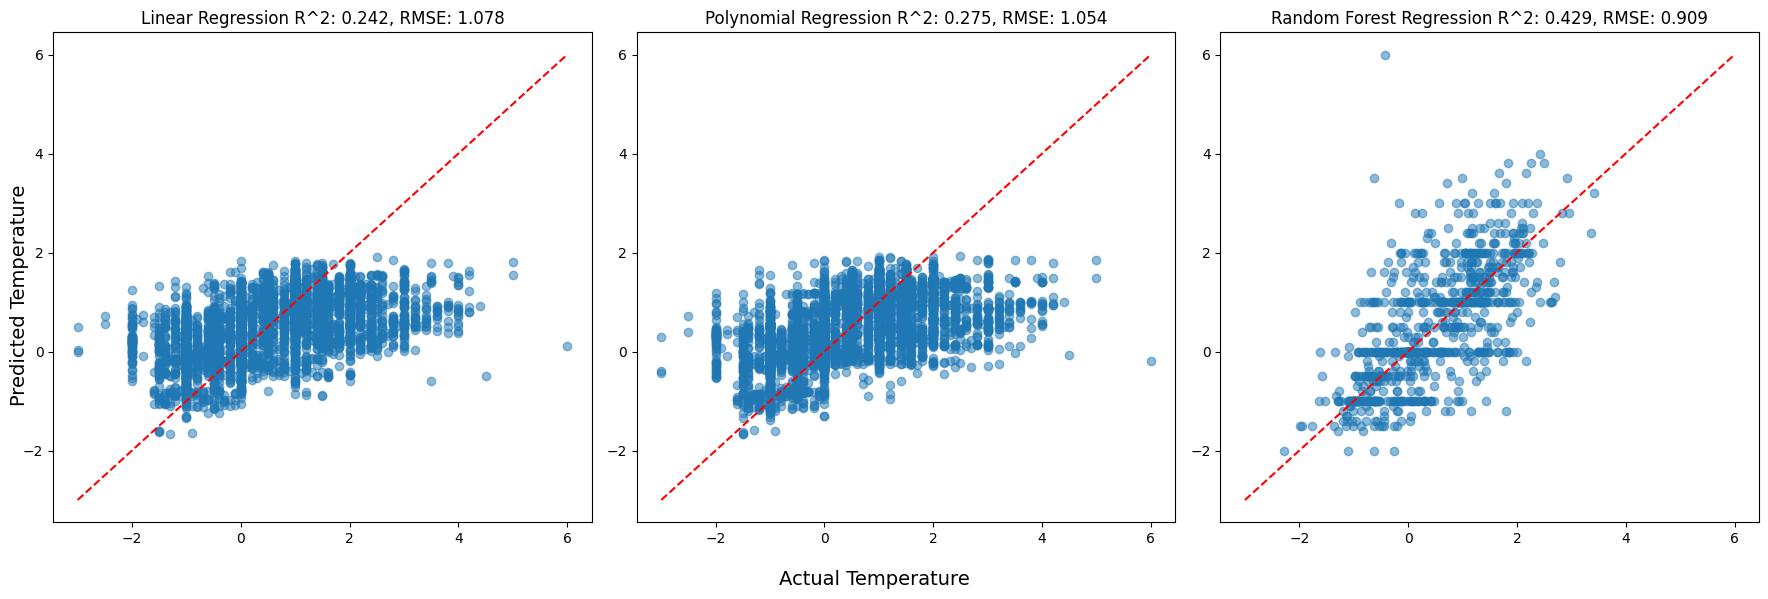

In [19]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))

#-------LINEAR REGRESSION R^2-------
ax[0].scatter(y, y_pred_lr, alpha=0.5)
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
ax[0].set_title(f'Linear Regression R^2: {r2_lr:.3f}, RMSE: {rmse_lr:.3f}')

#-------POLYNOMIAL REGRESSION R^2-------
ax[1].scatter(y, y_pred_poly,alpha=0.5)
ax[1].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
ax[1].set_title(f'Polynomial Regression R^2: {r2_poly:.3f}, RMSE: {rmse_poly:.3f}')

#-------RANDOM FOREST REGRESSION R^2-------
ax[2].scatter(x=y_pred_rf, y=y_test,alpha=0.5)
ax[2].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
ax[2].set_title(f'Random Forest Regression R^2: {r2_rf:.3f}, RMSE: {rmse_rf:.3f}')

fig.supxlabel('Actual Temperature', fontsize=14)
fig.supylabel('Predicted Temperature', fontsize=14)
# Set a reasonable y-axis range that works well visually
#common_ylim = (-5, 30)

#for a in ax:
#    a.set_xlim(-5, 30)
#   a.set_ylim(common_ylim)

plt.tight_layout()
plt.show()

#### 5.4.* For Random Forest only

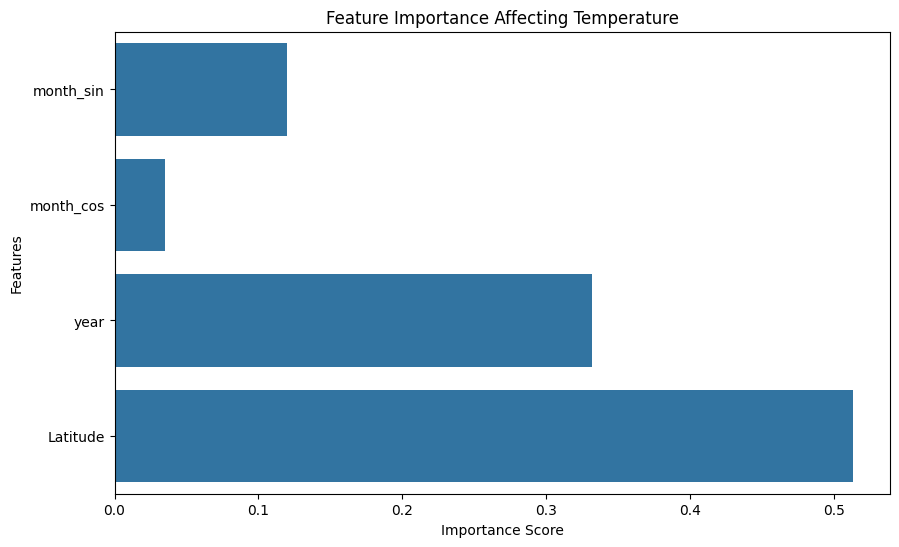

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x =rf_model.feature_importances_, y = x.columns)
plt.title('Feature Importance Affecting Temperature')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

#### Importance feature affect SST (extension)

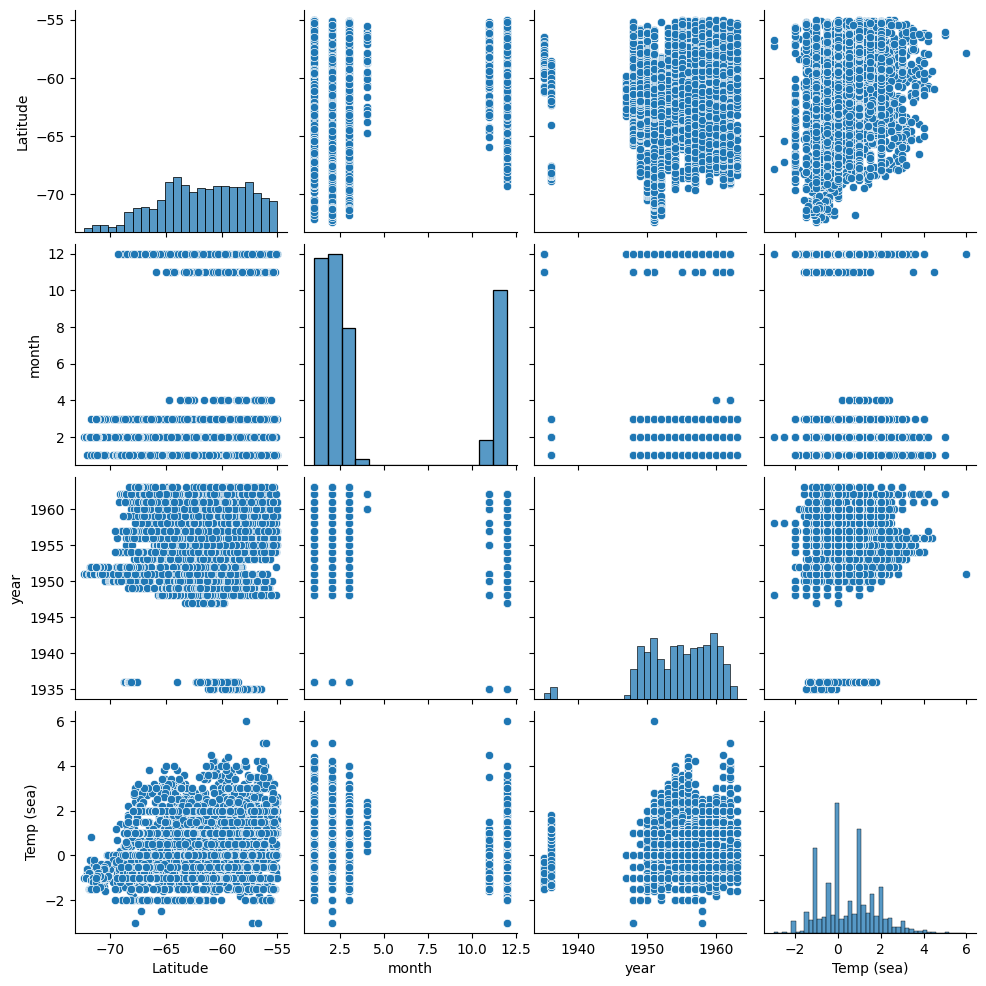

In [13]:
dlta['year'] = pd.to_datetime(dlta['date']).dt.year
sns.pairplot(dlta[['Latitude', 'month', 'year','Temp (sea)']])

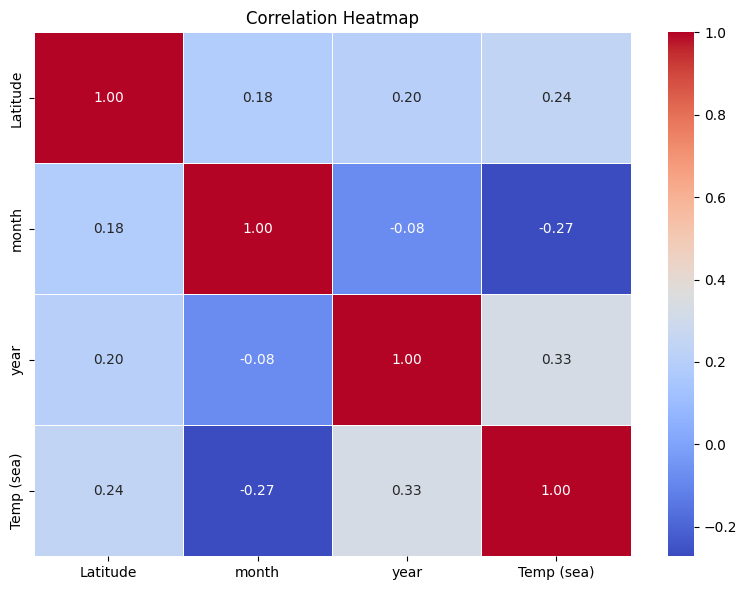

In [14]:
corr_matrix = dlta[['Latitude', 'month', 'year', 'Temp (sea)']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [15]:
feature = rf_model.feature_importances_
print("Feature importances:", feature)

feature = [1-(feature[2]+feature[3]), feature[2], feature[3]]
print("Feature importances (normalized):", feature)


Feature importances: [0.12017784 0.03532395 0.33163502 0.51286318]
Feature importances (normalized): [np.float64(0.15550179315460055), np.float64(0.3316350222402596), np.float64(0.5128631846051399)]


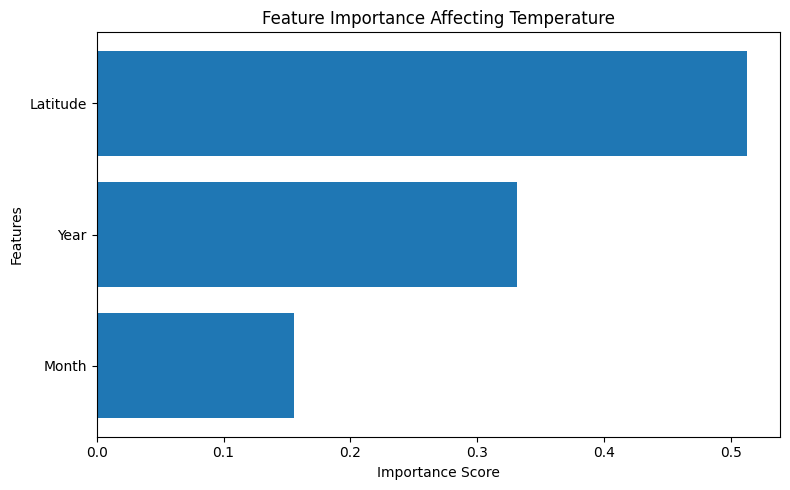

In [16]:
# Corresponding feature names (you removed month_cos from the original list)
feature_names = ['Month', 'Year', 'Latitude']

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, feature)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Affecting Temperature")
plt.tight_layout()
plt.show()

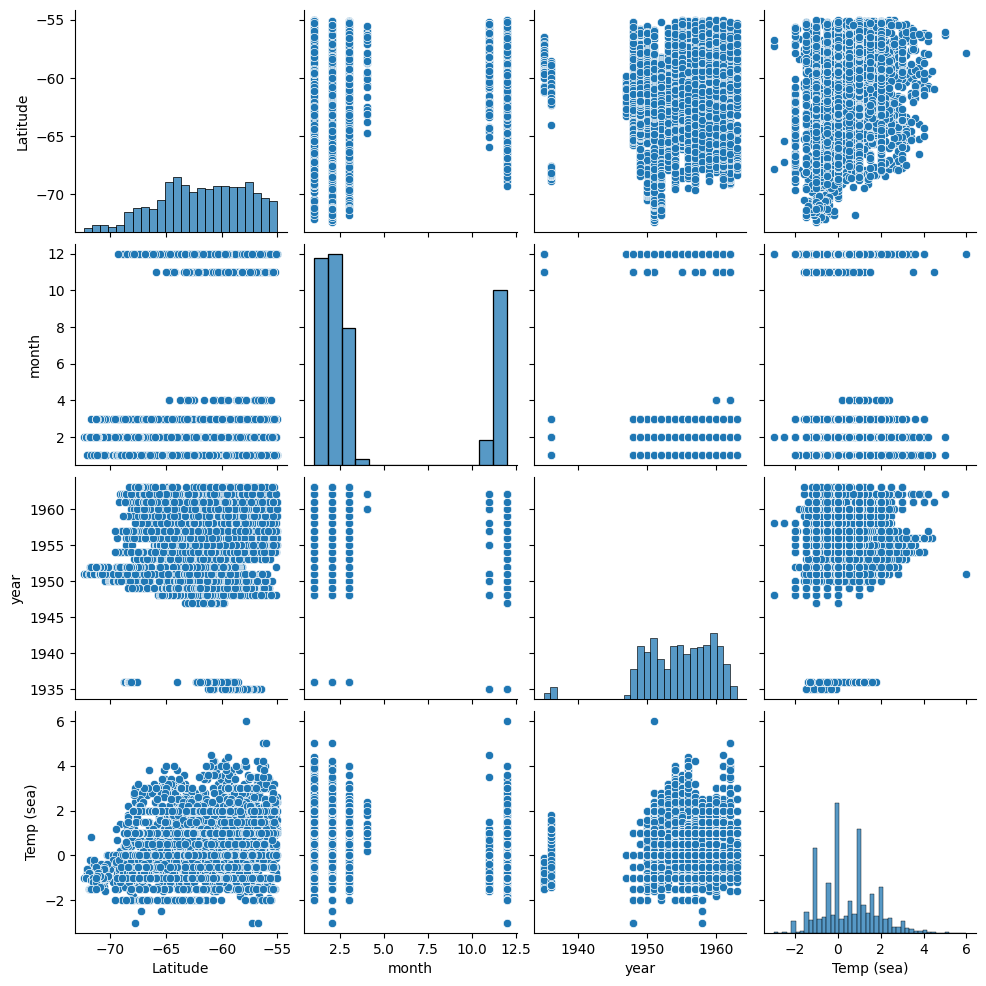

In [17]:
dlta = dlta[dlta['Latitude']<-55]

sns.pairplot(dlta[['Latitude', 'month', 'year','Temp (sea)']])

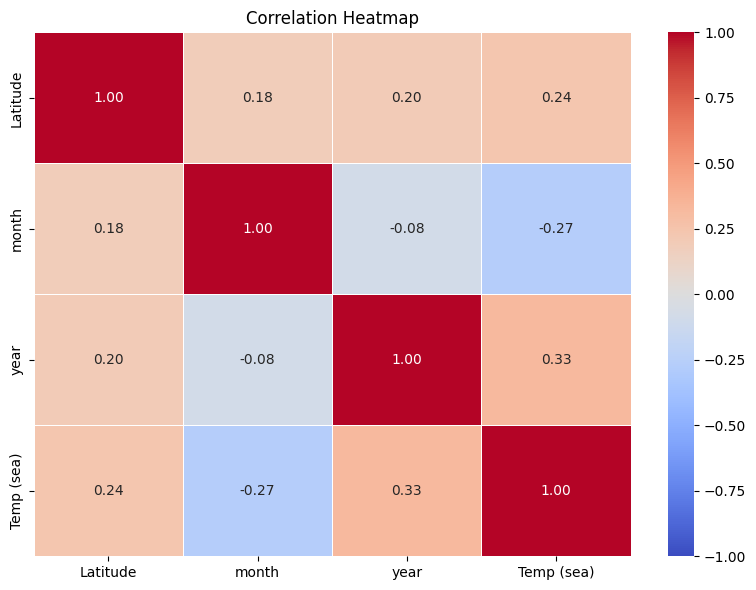

In [18]:
corr_matrix = dlta[['Latitude', 'month', 'year', 'Temp (sea)']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',     # red for positive, blue for negative
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1       # force color scale: blue = -1, red = +1
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()